In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

2025-05-15 04:22:16.569106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747282936.748112      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747282936.802724      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.18.0
Keras: 3.8.0
KerasNLP: 0.18.1


In [3]:
class CFG:
    seed = 42 #random seed
    preset = "deberta_v3_base_en" #name of pretrained models
    sequence_length = 384 #input sequence length
    epochs = 10 #training epochs
    batch_size = 8 #batch size
    scheduler = 'cosine' #learning rate scheduler
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [4]:
keras.utils.set_random_seed(CFG.seed)

In [5]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [6]:
BASE_PATH = '/kaggle/input/llm-classification-finetuning'

In [7]:
#load train data
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [8]:
# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(CFG.name2label)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


In [9]:
#load test data
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')

#take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null", "''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

test_df.head()

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [10]:
#define a function to create options based on the prompt and choices
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    row["options"] = [f"Prompt: {prompt}\n\nResponse: {response_a}",
                     f"Prompt: {prompt}\n\nResponse: {response_b}"]
    return row

In [11]:
df = df.apply(make_pairs, axis=1)
display(df.head(2))

test_df = test_df.apply(make_pairs, axis=1)
display(test_df.head(2))

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,encode_fail,options
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0,False,[Prompt: Is it morally right to try to have a ...
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1,False,[Prompt: What is the difference between marria...


,id,prompt,response_a,response_b,encode_fail,options
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...,False,"[Prompt: I have three oranges today, I ate an ..."
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...,False,[Prompt: You are a mediator in a heated politi...


In [12]:
df.encode_fail.value_counts(normalize=False)

encode_fail
False    56885
True       592
Name: count, dtype: int64

In [13]:
model_df = pd.concat([df.model_a, df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

#create a bar plot with custom styling using plotly
fig = px.bar(counts, x='LLM', y='Count',
             title='Distribution of LLMs',
             color='Count', color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [14]:
counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']

fig = px.bar(counts, x='Winner', y='Win Count',
             title='Winner distribution for train data',
             labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
             color='Winner', color_continuous_scale='viridis')
fig.update_layout(xaxis_title="Winner", yaxis_title="Win Count")

fig.show()

In [15]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

In [16]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,
    sequence_length=CFG.sequence_length
)

I0000 00:00:1747283004.199988      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
outs = preprocessor(df.options.iloc[0])

#display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

INFO:2025-05-15 04:23:25,034:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-15 04:23:25,045:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


token_ids : (2, 384)
padding_mask : (2, 384)


In [18]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)
    return (text, label) if label is not None else text

In [19]:
def build_dataset(texts, labels=None, batch_size=32, cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=3))
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    opt = tf.data.Options()
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTO)
    return ds

In [20]:
#train
train_texts = train_df.options.tolist()
train_labels = train_df.class_label.tolist()
train_ds = build_dataset(train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True)

#valid
valid_texts = valid_df.options.tolist()
valid_labels = valid_df.class_label.tolist()
valid_ds = build_dataset(valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False)

In [21]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch')
        plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

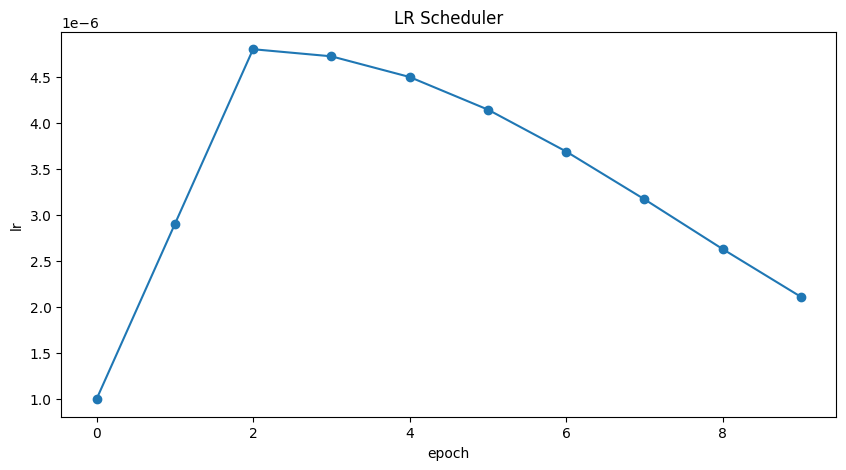

In [22]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [23]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                          monitor='val_log_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')

In [25]:
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor='val_log_loss',
    patience=2,
    restore_best_weights=True
)

In [26]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

In [27]:
#define input layers
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
}
#create a DebertaV3Classifier backbone
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    CFG.preset,
)

#compute embeddings for first response: (P + R_A) using backbone
response_a = {k: v[:, 0, :] for k, v in inputs.items()}
embed_a = backbone(response_a)

#compute embeddings for second response: (P + R_B), using the same backbone
response_b = {k: v[:, 1, :] for k, v in inputs.items()}
embed_b = backbone(response_b)

#compute final output
embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])
embeds = keras.layers.GlobalAveragePooling1D()(embeds)
outputs = keras.layers.Dense(3, activation='softmax', name="classifier")(embeds)
model = keras.Model(inputs, outputs)

#compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[
        log_loss,
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 2, None)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, 2, None)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, None)           │              0 │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, None)           │              0 │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, None)           │              0 │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, None)           │              0 │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deberta_v3_backbone       │ (None, None, 768)      │    183,831,552 │ get_item_1[0][0],      │
│ (DebertaV3Backbone)       │                        │                │ get_item[0][0],        │
│                           │                        │                │ get_item_3[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 1536)     │              0 │ deberta_v3_backbone[0… │
│                           │                        │                │ deberta_v3_backbone[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 1536)           │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier (Dense)        │ (None, 3)              │          4,611 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 183,836,163 (701.28 MB)

 Trainable params: 183,836,163 (701.28 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#start training the model
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb, early_stop_cb]
)

Epoch 1/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 5156s 884ms/step - accuracy: 0.4043 - log_loss: 1.0865 - loss: 1.0876 - val_accuracy: 0.4364 - val_log_loss: 1.0588 - val_loss: 1.0604 - learning_rate: 1.0000e-06
Epoch 2/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 4983s 854ms/step - accuracy: 0.4601 - log_loss: 1.0488 - loss: 1.0510 - val_accuracy: 0.4475 - val_log_loss: 1.0479 - val_loss: 1.0502 - learning_rate: 2.9000e-06
Epoch 3/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 4911s 854ms/step - accuracy: 0.4788 - log_loss: 1.0255 - loss: 1.0290 - val_accuracy: 0.4591 - val_log_loss: 1.0375 - val_loss: 1.0409 - learning_rate: 4.8000e-06
Epoch 4/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 4907s 854ms/step - accuracy: 0.5121 - log_loss: 0.9820 - loss: 0.9870 - val_accuracy: 0.4574 - val_log_loss: 1.0501 - val_loss: 1.0548 - learning_rate: 4.7230e-06
Epoch 5/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 4911s 854ms/step - accuracy: 0.5743 - log_loss: 0.9021 - loss: 0.9109 - val_accuracy: 0.4477 - val_log_loss: 1.1257 - val_loss: 1.1315 - l

In [30]:
model.load_weights('/kaggle/working/best_model.weights.h5')

In [31]:
#build test dataset
test_texts = test_df.options.tolist()
test_ds = build_dataset(test_texts,
                        batch_size=min(len(test_df), CFG.batch_size),
                        shuffle=False)

In [32]:
#make predictions using the trained model on test data
test_preds = model.predict(test_ds, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [33]:
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = test_preds.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.176025,0.430664,0.393066
1,211333,0.262695,0.338379,0.399170
2,1233961,0.099304,0.354004,0.546875
